## This notebook builds and trains our classification algorithm in the following order:
* Creates an appropriate train-test split of the data
* Implements appropriate data augmentation to training data
* Evaluates the performance of the model using appropriate statistics: 
    * monitors the training progress using log loss
    * uses precison, recall, and F1 score
    * finds a threshold to classify if an image has pneumonia or not
    
**Note:** The dataset is quite large (over 1GB) and is not uploaded to this github repo. If you wish to run the following code blocks locally after cloning this repo, download the data from https://www.kaggle.com/nih-chest-xrays/data and put it in "/data/". 

In [1]:
## Import dependencies
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import chain
from random import sample 
import sklearn.model_selection as skl

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix

Using TensorFlow backend.


## Preprocessing of our metadata for easier model training:

In [2]:
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
73102,00018006_019.png,Atelectasis|Effusion,19,18006,60,M,AP,2500,2048,0.168,0.168,NaN,/data/images_008/images/00018006_019.png
16200,00004340_001.png,No Finding,1,4340,65,M,AP,2500,2048,0.171,0.171,NaN,/data/images_003/images/00004340_001.png
11112,00002878_014.png,No Finding,14,2878,67,F,PA,2530,2991,0.143,0.143,NaN,/data/images_002/images/00002878_014.png


In [3]:
## Split up "Finding Labels" column so that there is one column in the NIH dataframe per disease, with a binary flag
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
90020,00022369_012.png,Effusion,12,22369,43,F,AP,3056,2504,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86640,00021374_017.png,Pneumothorax,17,21374,81,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
16456,00004382_000.png,Mass,0,4382,51,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [4]:
## Here we can create a new column called 'pneumonia_class' ('Yes' or 'No')that will allow us to look at 
## images with or without pneumonia for binary classification
all_xray_df['Pneumonia_class'] = ['Yes' if x == 1 else 'No' for x in all_xray_df['Pneumonia']]
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Pneumonia_class
15564,00004080_001.png,Effusion,1,4080,37,M,PA,2048,2500,0.171000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No
109568,00029813_018.png,Atelectasis|Effusion|Infiltration,18,29813,66,M,PA,2021,2021,0.194311,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,No
10365,00002686_000.png,No Finding,0,2686,52,M,PA,2500,2048,0.171000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,No


## Create training and testing data:

In [5]:
def create_splits(d, test_size, stratify, vp_to_vnp):
    
    """Use a built-in library to split the original dataframe into two sets: training and validation"""
    
    # Using skl built-in library to split dataset
    train_df, valid_df = skl.train_test_split(d,
                                              test_size = test_size,
                                              stratify = d[stratify])
    
    # Make sure the training set is balanced with 50% positive and 50% negative
    p_inds = train_df[train_df[stratify]==1].index.tolist()
    np_inds = train_df[train_df[stratify]==0].index.tolist()
    np_sample = sample(np_inds, len(p_inds))
    train_df = train_df.loc[p_inds + np_sample]
    
    # Here we make the validation set with a 'vp_to_np' ratio of positive to negative
    vp_inds = valid_df[valid_df[stratify]==1].index.tolist()
    vnp_inds = valid_df[valid_df[stratify]==0].index.tolist()
    vnp_sample = sample(vnp_inds, len(vp_inds)*vp_to_vnp)
    valid_df = valid_df.loc[vp_inds + vnp_sample]
    
    return train_df, valid_df

In [6]:
## Here we split our data with 20% postive cases in validation data
## and within validation data 30% is pneumonia
## which means there is 25% of pneumonia positive data in our validation set
splitted_df = create_splits(all_xray_df, 0.2, 'Pneumonia', 3)
train_df, valid_df = splitted_df[0], splitted_df[1]

## Print out some statistics to make sure our code behaves as expected
print(f'Total training data: {len(train_df)}')
print(f'Total validatin data: {len(valid_df)}')

t_p = train_df['Pneumonia'].sum()/len(train_df)
v_p = valid_df['Pneumonia'].sum()/len(valid_df)

print(f'Percentage of pneumonia positive case in our training set: {t_p}')
print(f'Percentage of pneumonia positive case in our validation set: {v_p}')

Total training data: 2290
Total validatin data: 1144
Percentage of pneumonia positive case in our training set: 0.5
Percentage of pneumonia positive case in our validation set: 0.25


# Model-building & training

In [7]:
def my_train_augmentation():
    
    """Perform image augmentation using Keras.ImageDataGenerator"""
    
    ## Note that we make this function taking in no arguments because
    ## there are a lot of ways to augment data and
    ## it would be easier to come into the scope of the function and direclt edit here
    my_idg = ImageDataGenerator(rescale=1. / 255.0,
                                horizontal_flip = True,
                                vertical_flip = False,
                                height_shift_range= 0.1,
                                width_shift_range=0.1,
                                rotation_range=20,
                                shear_range = 0.1,
                                zoom_range=0.1)
    
    return my_idg

def my_valid_augmentation():
    
    """Perform image augmentation using Keras.ImageDataGenerator"""
    
    ## Note that we make this function taking in no arguments because
    ## there are a lot of ways to augment data and
    ## it would be easier to come into the scope of the function and direclt edit here
    my_idg = ImageDataGenerator(rescale=1. / 255.0,
                                horizontal_flip = False,
                                vertical_flip = False,
                                height_shift_range= 0,
                                width_shift_range=0,
                                rotation_range=0,
                                shear_range = 0,
                                zoom_range=0)
    
    return my_idg


def make_train_gen(my_train_idg):
    
    """Create the actual generators using the output of my_image_augmentation for our training data"""

    ## Takes in training image data generator
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df,
                                                 directory=None,
                                                 x_col = 'path',
                                                 y_col = 'Pneumonia_class',
                                                 class_mode = 'binary',
                                                 target_size = (224, 224),
                                                 batch_size = 16)
    
    return train_gen


def make_val_gen(my_val_idg):
    
    """Create the actual generators using the output of my_image_augmentation for our validation data"""
    
    ## Takes in validation image data generator
    val_gen = my_val_idg.flow_from_dataframe(dataframe = valid_df,
                                             directory=None,
                                             x_col = 'path',
                                             y_col = 'Pneumonia_class',
                                             class_mode = 'binary',
                                             target_size = (224, 224),
                                             batch_size = 16)
    
    return val_gen

In [8]:
train_gen = make_train_gen(my_train_augmentation())

Found 2290 validated image filenames belonging to 2 classes.


In [9]:
val_gen = make_val_gen(my_valid_augmentation())

Found 1144 validated image filenames belonging to 2 classes.


In [10]:
## May want to pull a single large batch of random validation data for testing after each epoch
valX, valY = val_gen.next()

Train 0.0 1.0 0.4755114 0.22824173


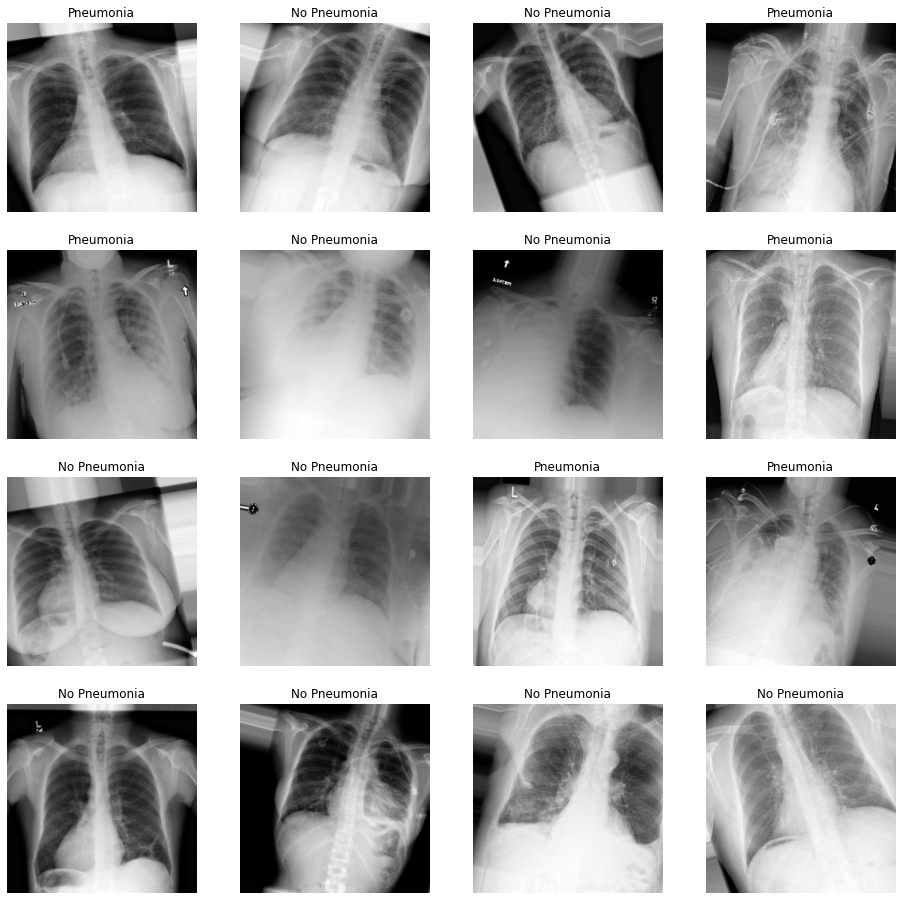

In [11]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation
t_x, t_y = next(train_gen)
print('Train', t_x.min(), t_x.max(), t_x.mean(), t_x.std())
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'gray')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

Train 0.0 1.0 0.522428 0.23826915


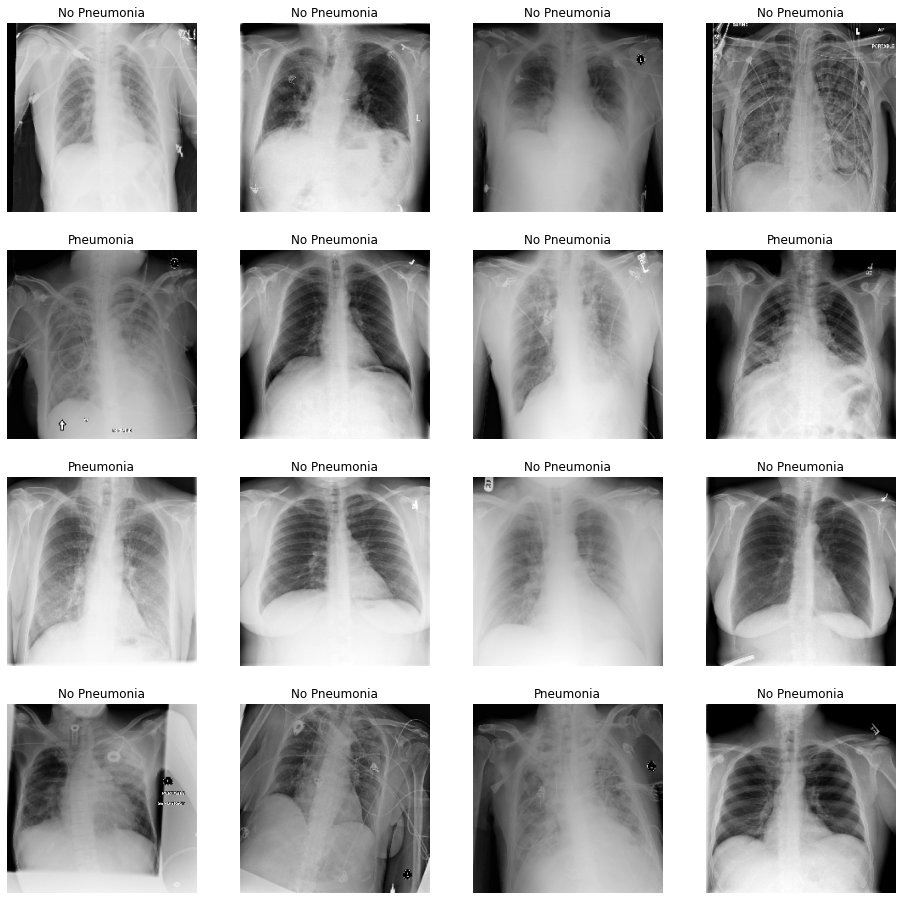

In [12]:
## May want to look at some examples of our UNaugmented validation data. 
v_x, v_y = next(val_gen)
print('Train', v_x.min(), v_x.max(), v_x.mean(), v_x.std())
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(v_x, v_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'gray')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

#### Looks good. Seems like we augmented our training set with some realistic parameters that we can expect to see in clinical settings. On top of that we did not augment our validation dataset because we should NOT. 

## Build model: 

In [13]:
def load_pretrained_model(pretrained_model, weights, lay_of_interest, up_to):
    
    """Load a pre-trained model and freeze layers that we do not intend to train"""
    
    ## Configure the pre-trained model
    model = pretrained_model(include_top=True, weights=weights)
    transfer_layer = model.get_layer(lay_of_interest)
    my_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    ## Freeze the lays that we do not intend to train 
    for layer in my_model.layers[0:up_to]:
        layer.trainable = False
    
    return my_model

In [14]:
def build_my_model(pre_trained_model):
    
    """Add pre-trained model and additional layers for fine-tuning (Flatteen, Dense, Dropout, etc.)"""
    
    my_model = Sequential()

    # Add the convolutional part of the VGG16 model from above.
    my_model.add(pre_trained_model)

    # Flatten the output of the VGG16 model because it is from a
    # convolutional layer.
    my_model.add(Flatten())

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dense(1024, activation='relu'))

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    my_model.add(Dropout(0.25))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dense(512, activation='relu'))

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    my_model.add(Dropout(0.25))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dense(256, activation='relu'))

    # Add a dense (aka. fully-connected) layer.
    # Change the activation function to sigmoid 
    # so output of the last layer is in the range of [0,1] 
    my_model.add(Dense(1, activation='sigmoid'))
    
    # Make sure to set optimizer, loss function, and metrics to monitor
    optimizer = Adam(lr=1e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    
    # Compile model
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return my_model

## TO DO: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [15]:
## Helper code that will allow us to add checkpoints to our model,
## This will save the 'best' version of our model by comparing it to previous epochs of training
weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             save_weights_only = True)

early = EarlyStopping(monitor='val_loss', 
                      mode='min', 
                      patience=7)

callbacks_list = [checkpoint, early]

In [16]:
vgg_model = load_pretrained_model(VGG16, 'imagenet', 'block5_pool', 17)
my_model = build_my_model(vgg_model)

## Start training:

In [17]:
## Train model
history = my_model.fit_generator(train_gen, 
                                 validation_data = (valX, valY), 
                                 epochs = 10,
                                 callbacks = callbacks_list)

Epoch 1/10
144/144 [==============================] - 65s 454ms/step - loss: 0.7225 - binary_accuracy: 0.5293 - val_loss: 0.6730 - val_binary_accuracy: 0.6250

Epoch 00001: val_loss improved from inf to 0.67299, saving model to xray_class_my_model.best.hdf5
Epoch 2/10
144/144 [==============================] - 61s 420ms/step - loss: 0.6826 - binary_accuracy: 0.5690 - val_loss: 0.7303 - val_binary_accuracy: 0.5000

Epoch 00002: val_loss did not improve from 0.67299
Epoch 3/10
144/144 [==============================] - 59s 412ms/step - loss: 0.6721 - binary_accuracy: 0.5852 - val_loss: 0.5067 - val_binary_accuracy: 0.9375

Epoch 00003: val_loss improved from 0.67299 to 0.50671, saving model to xray_class_my_model.best.hdf5
Epoch 4/10
144/144 [==============================] - 60s 419ms/step - loss: 0.6585 - binary_accuracy: 0.6066 - val_loss: 0.6180 - val_binary_accuracy: 0.8125

Epoch 00004: val_loss did not improve from 0.50671
Epoch 5/10
144/144 [==============================] - 62s 

##### After training for some time, look at the performance of our model by plotting some performance statistics:

In [18]:
## After training, make some predictions to assess our model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size=16, verbose=True)

16/16 [==============================] - 0s 17ms/step


In [19]:
def plot_auc(t_y, p_y):
    
    """Plot AUC - Area Under The Curve"""
    
    fig, c_ax = plt.subplots(1, 1, figsize=(5, 5))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    
    return

def plot_pr(t_y, p_y):
    
    """Plot ROC - Receiver Operating Characteristics curve"""

    fig, c_ax = plt.subplots(1, 1, figsize=(5, 5))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(precision, recall, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')
    
    return

def calc_f1(prec,recall):
    
    """Calculate F1 score - a measure of a test's accuracy"""

    return 2*(prec*recall)/(prec+recall)
    
def plot_history(history):
    
    """Plot the hostory of model training"""
    
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure(figsize=(5, 5))
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    
    return

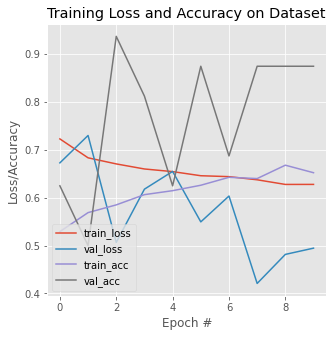

In [20]:
plot_history(history)

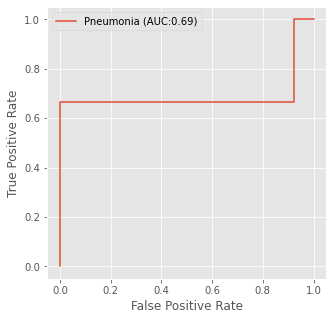

In [21]:
plot_auc(valY, pred_Y)

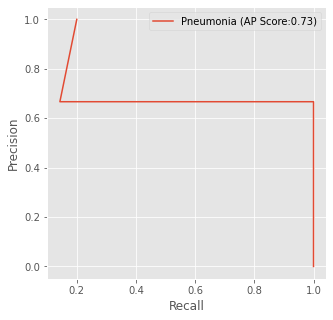

In [22]:
plot_pr(valY, pred_Y)

In [23]:
## Precison, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(valY, pred_Y)

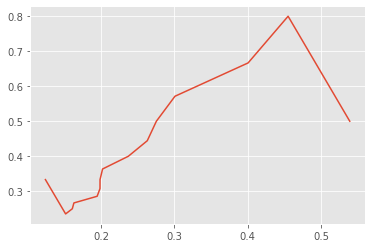

In [24]:
## Let's see how our F1-score changes as threshold increases
f1 = []

for prec, rec in zip(precision, recall):
    score = calc_f1(prec, rec)
    f1.append(score)
    
plt.plot(thresholds, f1[:-1])

In [25]:
my_threshold = thresholds[f1.index(max(f1))]

In [26]:
## Look at the threshold where F1 is at its maximum
threshold_value = my_threshold
idx = (np.abs(thresholds - threshold_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

Precision is: 1.0
Recall is: 0.6666666666666666
Threshold is: 0.45522758
F1 Score is: 0.8


Once we feel we are done training, we'll need to decide the proper classification threshold that optimizes our model's performance for a given metric (e.g. accuracy, F1, precision, etc.) 

In [27]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.
testY = pred_Y.ravel()
for i in range(len(testY)):
    if testY[i] < my_threshold:
        testY[i] = 0
    else:
        testY[i] = 1

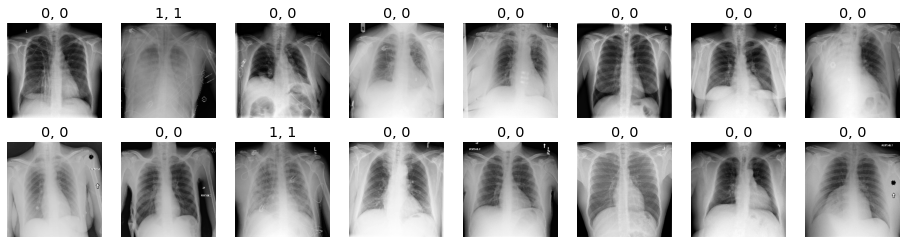

In [28]:
## Let's look at some examples of true vs. predicted with our best model: 
fig, m_axs = plt.subplots(2, 8, figsize = (16, 4))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:16], testY[0:16], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'gray')
    if c_y == 1: 
        if pred_Y[i] > my_threshold:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > my_threshold: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [29]:
## Just save model architecture to a .json:
model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)